# Correlación entre temperatura, humedad y lluvia.

Generaremos datos sintéticos que conformen un dataset con las siguientes variables explicativas:

Temperatura máxima del día.

Temperatura de las 15hs.

Humedad media diaria


y cuya variable Target será "Llovió" (puede tomar dos posibles valores: "si" o "no".)

A priori: la temperatura máxima del día debería ser muy similar a la de las 15hs, verdad? De hecho, la mayoría de los días debería suceder eso. ¿Cuándo podría no suceder? Bueno, cuando ocurran fenómenos meteorológicos como por ejemplo, tormentas, justo nuestra variable Target.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
np.random.seed(42)
n = 1000

# variables base
humedad = np.random.uniform(40, 90, n)
temp_max = np.random.uniform(15, 35, n)

# creamos temp_3pm con alta correlación, pero separada en días de lluvia
temp_3pm = temp_max - np.random.uniform(0, 5, n)  # en días normales, similar a Temp_max
llueve = (temp_max - temp_3pm > 3) & (humedad > 70)  # vamos a definir días de lluvia cuando haya diferencia importante entre Temp 3pm y Temp max, y además cuando haya cierta humedad.

# convertimos a DataFrame
df = pd.DataFrame({"Humedad": humedad, "Temp_3pm": temp_3pm, "Temp_max": temp_max, "Lluvia": llueve.astype(int)})

# vamos a ir creando una variable que mida la diferencia entre Temp_max y Temp_3pm, aunque no necesariamente la vamos a utilizar (Recordar, primero queremos analizar la correlación)
df['Diff_Temp'] = df['Temp_max'] - df['Temp_3pm']

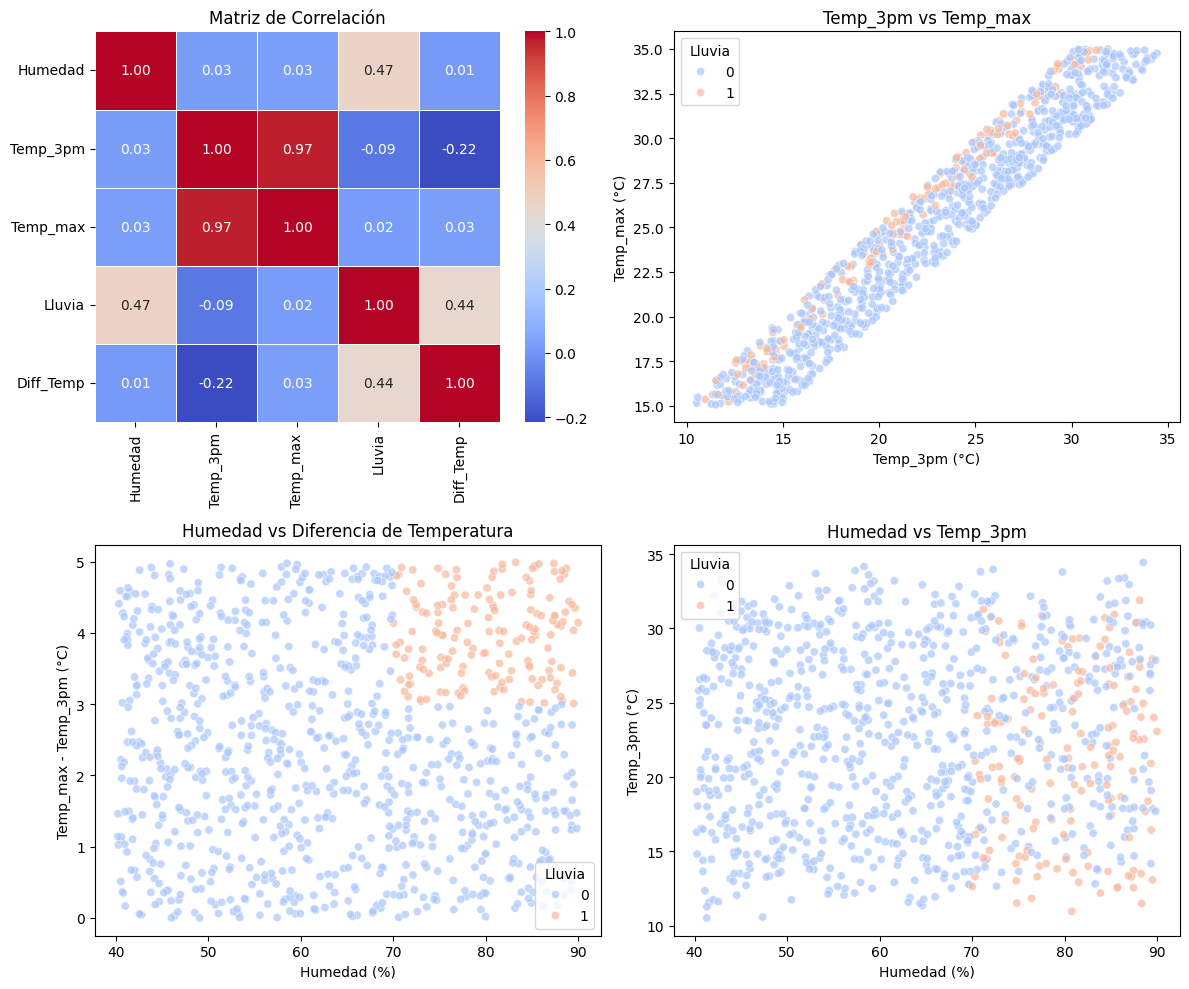

In [3]:
# matriz de correlación
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=100)

sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, ax=axes[0, 0])
axes[0, 0].set_title("Matriz de Correlación")

# scatterplots
sns.scatterplot(x=df["Temp_3pm"], y=df["Temp_max"], hue=df["Lluvia"], ax=axes[0, 1], alpha=0.7, palette="coolwarm")
axes[0, 1].set_title("Temp_3pm vs Temp_max")
axes[0, 1].set_xlabel("Temp_3pm (°C)")
axes[0, 1].set_ylabel("Temp_max (°C)")

sns.scatterplot(x=df["Humedad"], y=df["Temp_max"] - df["Temp_3pm"], hue=df["Lluvia"], ax=axes[1, 0], alpha=0.7, palette="coolwarm")
axes[1, 0].set_title("Humedad vs Diferencia de Temperatura")
axes[1, 0].set_xlabel("Humedad (%)")
axes[1, 0].set_ylabel("Temp_max - Temp_3pm (°C)")

sns.scatterplot(x=df["Humedad"], y=df["Temp_3pm"], hue=df["Lluvia"], ax=axes[1, 1], alpha=0.7, palette="coolwarm")
axes[1, 1].set_title("Humedad vs Temp_3pm")
axes[1, 1].set_xlabel("Humedad (%)")
axes[1, 1].set_ylabel("Temp_3pm (°C)")

plt.tight_layout()
plt.show()



Notamos que las variables Temp 3pm y Temp max están altamente correlacionadas. De hecho, en el scatterplot, vemos lo mismo. Pero a la vez, hemos ploteado los puntos de lluvia en ese mismo scatterplot, y se observa un patrón. ¿lo notás?

Probaremos distintos modelos: descartando la variable Temp 3pm (suponiendo que podemos hacerlo, por su elevada correlación con Temp max), luego haremos otro modelo donde usaremos ambas, y por un último un modelo que use UNA de ellas y una variable nueva que es su DIFERENCIA. Notar que la DIFERENCIA no tiene correlación con ninguna de las dos.

# modelos de clasificación LINEALES (si son LINEALES, no deberíamos tener diferencia entre los últimos dos modelos, verdad? qué te parece?)

In [4]:
y = df["Lluvia"]
X = df.drop(columns=["Lluvia"])

# split de datos. Ojo, esto debería hacerse antes de ver correlación, pero estamos haciendo un ejemplo.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_df = pd.DataFrame(X_train, columns=["Humedad", "Temp_3pm", "Temp_max", "Diff_Temp"])
X_test_df = pd.DataFrame(X_test, columns=["Humedad", "Temp_3pm", "Temp_max", "Diff_Temp"])

X1_train = X_train_df[["Humedad", "Temp_max"]] # modelo 1: excluye Temp_3pm
X2_train = X_train_df[["Humedad", "Temp_3pm", "Temp_max"]]  # modelo 2: usa ambas temperaturas
X3_train = X_train_df[["Humedad", "Temp_max", "Diff_Temp"]] # modelo 3: usa la diferencia entre Temp_max y Temp_3pm
X1_test = X_test_df[["Humedad", "Temp_max"]]
X2_test = X_test_df[["Humedad", "Temp_3pm", "Temp_max"]]
X3_test = X_test_df[["Humedad", "Temp_max", "Diff_Temp"]]

# y_Train e y_test son las mismas para todos los modelos, ya que la variable objetivo es la misma.

# entrenamos modelos LINEALES de clasificación: la regresión logística.
modelo1 = LogisticRegression().fit(X1_train, y_train)
modelo2 = LogisticRegression().fit(X2_train, y_train)
modelo3 = LogisticRegression().fit(X3_train, y_train)

# predicciones en test
y_pred1 = modelo1.predict(X1_test)
y_pred2 = modelo2.predict(X2_test)
y_pred3 = modelo3.predict(X3_test)

# evaluación en este caso del ACCURACY. Más adelante veremos como elegir métricas adecuadamente para CLASIFICACIÓN.
acc1 = accuracy_score(y_test, y_pred1)
acc2 = accuracy_score(y_test, y_pred2)
acc3 = accuracy_score(y_test, y_pred3)

# print de resultados
print(f"Modelo 1 (Sin Temp_3pm): Acc = {acc1:.3f}")
print(f"Modelo 2 (Con ambas temperaturas): Acc = {acc2:.3f}")
print(f"Modelo 3 (Con diferencia Temp_max - Temp_3pm): Acc = {acc3:.3f}")

Modelo 1 (Sin Temp_3pm): Acc = 0.820
Modelo 2 (Con ambas temperaturas): Acc = 0.950
Modelo 3 (Con diferencia Temp_max - Temp_3pm): Acc = 0.950


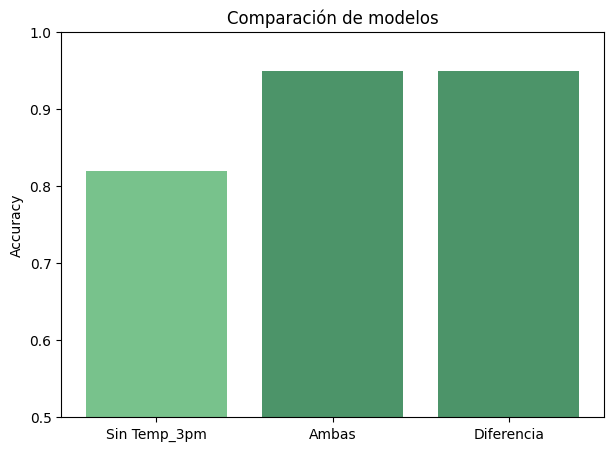

In [ ]:
# veamos los resultados en un gráfico para hacer una comparación visual. Asignaremos colores más intensos a los modelos con mejor accuracy.

accs = [acc1, acc2, acc3]
colors = sns.color_palette("Greens", 100)
colors = [colors[int(200*(acc-0.5))] for acc in accs]


plt.figure(figsize=(7, 5))
plt.bar(["Sin Temp_3pm", "Ambas", "Diferencia"], accs, color=colors, alpha=0.7)
plt.ylim(0.5, 1)
plt.ylabel("Accuracy")
plt.title("Comparación de modelos")

plt.show()

El modelo que usa ambas variables performa mucho mejor que el primero. ¿Por qué?

Entrenaremos un modelo distinto, RandomForest (mucho más complejo), para ver qué diferencias encontramos en estos tres casos.

In [5]:
from sklearn.ensemble import RandomForestClassifier

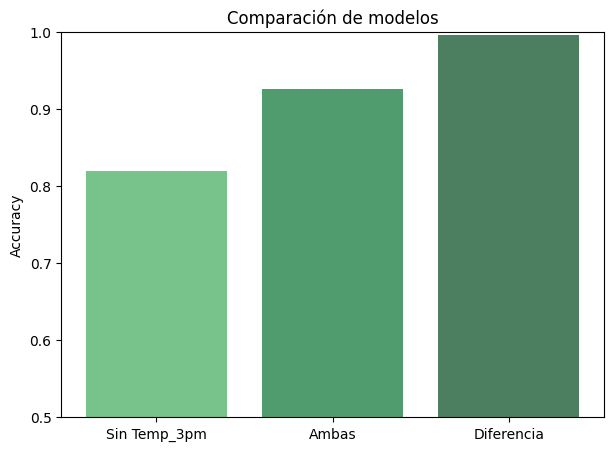

In [6]:
modelo1 = RandomForestClassifier(n_estimators=100, random_state=42).fit(X1_train, y_train)
modelo2 = RandomForestClassifier(n_estimators=100, random_state=42).fit(X2_train, y_train)
modelo3 = RandomForestClassifier(n_estimators=100, random_state=42).fit(X3_train, y_train)

y_pred1 = modelo1.predict(X1_test)
y_pred2 = modelo2.predict(X2_test)
y_pred3 = modelo3.predict(X3_test)

acc1 = accuracy_score(y_test, y_pred1)
acc2 = accuracy_score(y_test, y_pred2)
acc3 = accuracy_score(y_test, y_pred3)


accs = [acc1, acc2, acc3]
colors = sns.color_palette("Greens", 100)
colors = [colors[int(200*(acc-0.5))] for acc in accs]


plt.figure(figsize=(7, 5))
plt.bar(["Sin Temp_3pm", "Ambas", "Diferencia"], accs, color=colors, alpha=0.7)
plt.ylim(0.5, 1)
plt.ylabel("Accuracy")
plt.title("Comparación de modelos")

plt.show()

# Notar que el mejor desempeño se consigue con el preprocesamiento de datos en donde se incluye una nueva característica. De aquí, que el Feature Engineering es muy importante. No se puede descartar variables por alta correlación sin una correcta justificación. Si en este ejemplo lo hubiésemos hecho, tendríamos un Accuracy pobre.